<a href="https://colab.research.google.com/github/GarimaSharda/Kaggle-Knowledge-Project-Titanic/blob/main/Kaggle_Titanic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load data and inspect first rows**
This cell reads the Titanic train and test CSV files into pandas DataFrames and displays the first few rows. It helps verify that the files are loaded correctly and shows the available columns (PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked).

In [2]:
# Step 1: Upload local CSV file from your computer
from google.colab import files
uploaded = files.upload()

# Step 2: Load it into pandas
import pandas as pd
train = pd.read_csv('train.csv')

# Step 3: Check the data
train.head()


Saving train.csv to train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Upload gender_submission.csv from your computer
uploaded = files.upload()

# Read into pandas
gender_submission = pd.read_csv('gender_submission.csv')

# Display first few rows
gender_submission.head()


Saving gender_submission.csv to gender_submission.csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
# Upload file manually from your computer
uploaded = files.upload()

# Load CSV file into a DataFrame
test = pd.read_csv('test.csv')

# Display the first few rows
test.head()

Saving test.csv to test.csv


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Check shapes and missing values**
This cell prints the number of rows and columns in train and test, then counts missing values in each column. It gives an overview of data completeness and tells which features (Age, Cabin, Embarked, Fare) need imputation before modeling.

In [5]:
#Get the number of entries in each file
train_len = len(train)
test_len = len(test)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("Number of entries in train.csv:", train_len)
print("Number of entries in test.csv:", test_len)

Train shape: (891, 12)
Test shape: (418, 11)
Number of entries in train.csv: 891
Number of entries in test.csv: 418


In [6]:
#check null value
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# **Engineer features**
This cell extracts the numeric part at the end of each Ticket string and stores it in a new column Ticket_Number. Converting complex ticket codes into a numeric identifier can capture patterns such as groups of passengers sharing similar ticket numbers.

We fill in missing Age values using the median age within each (Sex, Pclass) group, so that age estimates respect passenger demographics. It fills missing Embarked values in the training data with the most common port and fills the single missing Fare in the test data with the median fare for that passenger class. It also creates a binary HasCabin flag indicating whether a cabin entry exists and then drops the original, mostly empty Cabin column.

In this cell we also make sure FamilySize counts how many family members travel together (SibSp + Parch + 1), and IsAlone indicates passengers traveling alone. It also extracts Title (Mr, Mrs, Miss, Master, etc.) from the Name column and groups rare titles together. These features can improve the model by capturing social status and family structure, both of which affected survival chances.

In [7]:
# Ticket_Number for both train and test
for df in [train, test]:
    df["Ticket_Number"] = df["Ticket"].astype(str).str.extract(r"(\d+)$", expand=False)
    df["Ticket_Number"] = pd.to_numeric(df["Ticket_Number"], errors="coerce")

# Age: median by Sex and Pclass
for df in [train, test]:
    df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(
        lambda x: x.fillna(x.median())
    )

# Embarked (train): fill with mode
embarked_mode = train["Embarked"].mode()[0]
train["Embarked"] = train["Embarked"].fillna(embarked_mode)

# Fare (test): fill with median by Pclass
test["Fare"] = test.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(x.median())
)

# Cabin → HasCabin, then drop Cabin
for df in [train, test]:
    df["HasCabin"] = df["Cabin"].notna().astype(int)
    df.drop(columns=["Cabin"], inplace=True)

# FamilySize, IsAlone, Title
for df in [train, test]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
    df["Title"] = df["Title"].replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev",
         "Sir", "Jonkheer", "Dona"],
        "Rare"
    )
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})


# **Encode categorical features for modeling**
This cell converts text categories into numeric form. It maps Sex to 0/1 and applies one‑hot encoding to Embarked and Title, creating separate indicator columns for each category. This transformation is required because most machine learning algorithms work with numerical inputs only.

In [8]:
# Encode Sex
for df in [train, test]:
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1}).astype(int)

# One‑hot encode Embarked and Title
train = pd.get_dummies(train, columns=["Embarked", "Title"], drop_first=True)
test  = pd.get_dummies(test,  columns=["Embarked", "Title"], drop_first=True)

# Make sure train and test have identical columns
train, test = train.align(test, join="left", axis=1, fill_value=0)

train.columns, test.columns


(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Ticket_Number', 'HasCabin', 'FamilySize',
        'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
        'Title_Mrs', 'Title_Rare', 'Title_the Countess'],
       dtype='object'),
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Ticket_Number', 'HasCabin', 'FamilySize',
        'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
        'Title_Mrs', 'Title_Rare', 'Title_the Countess'],
       dtype='object'))

# **Prepare feature matrix X and target y**
This cell removes identifier and raw text columns (PassengerId, Name, Ticket) that are not directly useful as numeric features. It then defines X as the set of model features and y as the Survived target variable from the training data.

This cell also splits the data into training and validation sets, fits a classification model (for example, a Random Forest) on the training subset, and evaluates it on the validation subset using accuracy. This gives an estimate of how well the model generalizes before using it to make test‑set predictions.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

target = "Survived"
drop_cols = ["PassengerId", "Name", "Ticket"]

train_model = train.drop(columns=drop_cols)
test_model = test.drop(columns=drop_cols + [target], errors="ignore")

X = train_model.drop(columns=[target])
y = train_model[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Validation accuracy:", accuracy_score(y_valid, rf.predict(X_valid)))


Validation accuracy: 0.8100558659217877


# **Fit on all data and generate Kaggle submission**
This cell retrains the chosen model on the full training dataset to use all available labeled examples. It then applies the model to the processed test features to predict Survived for each passenger and saves the results as submission.csv with the required PassengerId and Survived columns for uploading to Kaggle.

In [10]:
rf.fit(X, y)
test_pred = rf.predict(test_model)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# **Further Advancements**


*   Visualize survival patterns and look at interactions
*   Refine Exisiting features and applying new ideas and various models
*   Try tuning hyperparamters and much more



In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


# **1. Deeper EDA and storytelling**
Survival by sex, class, and embarkation

   Sex  Survived
0    0  0.188908
1    1  0.742038


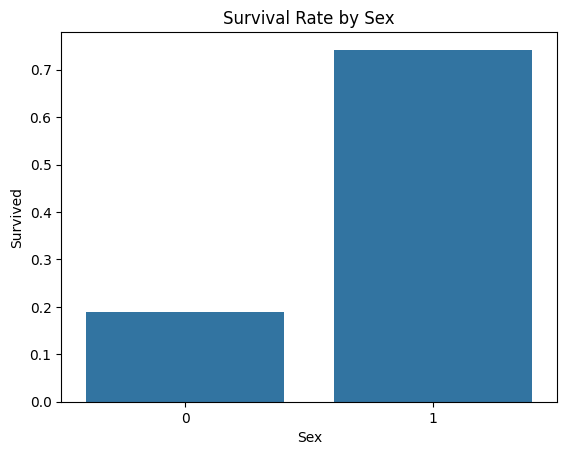

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


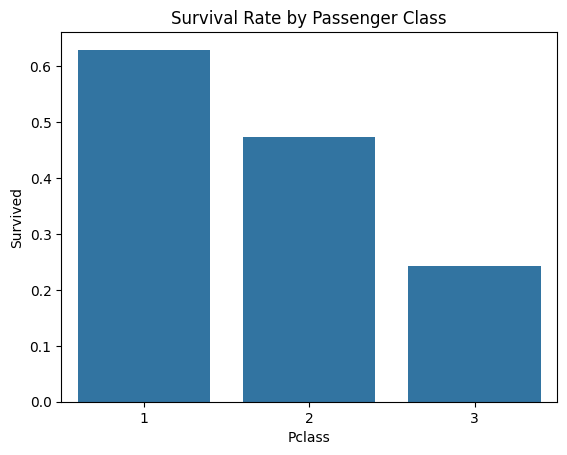

In [12]:
# Survival rate by Sex
sex_survival = train.groupby("Sex")["Survived"].mean().reset_index()
print(sex_survival)

sns.barplot(data=sex_survival, x="Sex", y="Survived")
plt.title("Survival Rate by Sex")
plt.show()

# Survival rate by Pclass
pclass_survival = train.groupby("Pclass")["Survived"].mean().reset_index()
print(pclass_survival)

sns.barplot(data=pclass_survival, x="Pclass", y="Survived")
plt.title("Survival Rate by Passenger Class")
plt.show()

# Survival rate by Embarked (if one-hot encoded, compute from original train before dummies)
if "Embarked" in train.columns:
    embarked_survival = train.groupby("Embarked")["Survived"].mean().reset_index()
    print(embarked_survival)
    sns.barplot(data=embarked_survival, x="Embarked", y="Survived")
    plt.title("Survival Rate by Port the Passengers Embark On")
    plt.show()


Survival vs age and family size

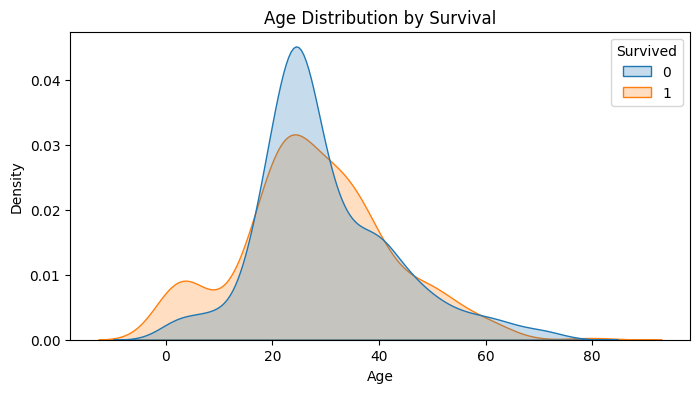

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


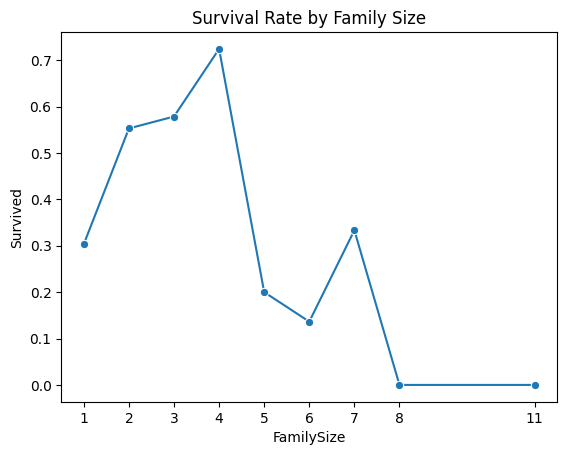

In [13]:
# Create FamilySize if it does not exist yet
if "FamilySize" not in train.columns:
    train["FamilySize"] = train["SibSp"] + train["Parch"] + 1

# Age distribution separated by Survived
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train, x="Age", hue="Survived", common_norm=False, fill=True)
plt.title("Age Distribution by Survival")
plt.show()

# FamilySize vs survival (assuming you created FamilySize)
family_survival = train.groupby("FamilySize")["Survived"].mean().reset_index()
print(family_survival)

sns.lineplot(data=family_survival, x="FamilySize", y="Survived", marker="o")
plt.title("Survival Rate by Family Size")
plt.xticks(family_survival["FamilySize"].unique())
plt.show()


Interaction plots: sex × class

Pclass         1         2         3
Sex                                 
0       0.368852  0.157407  0.135447
1       0.968085  0.921053  0.500000


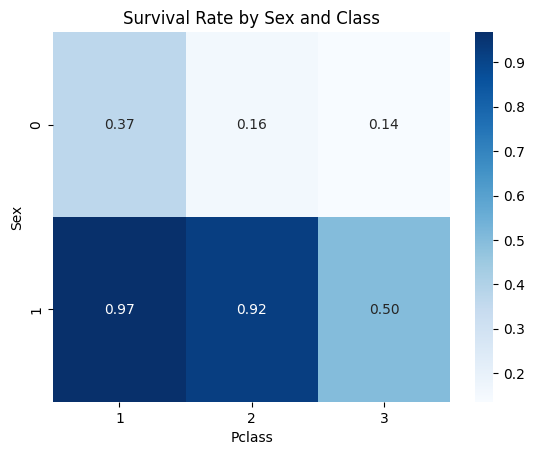

In [14]:
sex_pclass = train.pivot_table(
    index="Sex", columns="Pclass", values="Survived", aggfunc="mean"
)
print(sex_pclass)

sns.heatmap(sex_pclass, annot=True, fmt=".2f", cmap="Blues")
plt.title("Survival Rate by Sex and Class")
plt.show()


# **2. Advanced feature engineering**
Age and fare bands

In [15]:
# Age bands
train["AgeBand"] = pd.cut(train["Age"], bins=[0, 12, 18, 30, 50, 80], labels=False)
test["AgeBand"]  = pd.cut(test["Age"],  bins=[0, 12, 18, 30, 50, 80], labels=False)

# Fare bands
train["FareBand"] = pd.qcut(train["Fare"], 4, labels=False, duplicates="drop")
test["FareBand"]  = pd.qcut(test["Fare"], 4, labels=False, duplicates="drop")

train[["Age", "AgeBand", "Fare", "FareBand"]].head()


,Age,AgeBand,Fare,FareBand
0,22.0,2,7.2500,0
1,38.0,3,71.2833,3
2,26.0,2,7.9250,1
3,35.0,3,53.1000,3
4,35.0,3,8.0500,1


Deck from Cabin (if you still have Cabin in an earlier copy)

In [16]:
# Remove Deck if it was partially created
for df in [train, test]:
    for col in ["Deck"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

# Ensure we have HasCabin and no Cabin in either df
for df in [train, test]:
    if "Cabin" in df.columns:
        df["HasCabin"] = df["Cabin"].notna().astype(int)
        df.drop(columns=["Cabin"], inplace=True)
    elif "HasCabin" not in df.columns:
        # if Cabin was already dropped earlier, at least create a default flag
        df["HasCabin"] = 0

raw_train = pd.read_csv("train.csv")
raw_test  = pd.read_csv("test.csv")

def extract_deck(cabin):
    if pd.isna(cabin):
        return "M"
    return str(cabin)[0]

raw_train["Deck"] = raw_train["Cabin"].apply(extract_deck)
raw_test["Deck"]  = raw_test["Cabin"].apply(extract_deck)

# You can then compute EDA on raw_train[['Deck','Survived']] without touching your main train/test
deck_survival = raw_train.groupby("Deck")["Survived"].mean().reset_index()
print(deck_survival)
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())


  Deck  Survived
0    A  0.466667
1    B  0.744681
2    C  0.593220
3    D  0.757576
4    E  0.750000
5    F  0.615385
6    G  0.500000
7    M  0.299854
8    T  0.000000
Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Ticket_Number', 'HasCabin', 'FamilySize', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'AgeBand', 'FareBand']
Test columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Ticket_Number', 'HasCabin', 'FamilySize', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'AgeBand', 'FareBand']


Ticket group size and fare per person

In [17]:
# Ticket group size
ticket_counts = train["Ticket"].value_counts()
train["TicketGroupSize"] = train["Ticket"].map(ticket_counts)

# For test, combine counts from both sets to avoid leakage of ticket not in train
all_tickets = pd.concat([train["Ticket"], test["Ticket"]])
ticket_counts_all = all_tickets.value_counts()
test["TicketGroupSize"] = test["Ticket"].map(ticket_counts_all)

# Average fare per ticket (fare split across group)
train["FarePerPerson"] = train["Fare"] / train["TicketGroupSize"]
test["FarePerPerson"]  = test["Fare"] / test["TicketGroupSize"]


Refined child indicator

In [18]:
# Encode Sex safely
for df in [train, test]:
    df["Sex"] = (
        df["Sex"]
        .map({"male": 0, "female": 1})
        .fillna(-1)               # fallback for unexpected / missing values
        .astype(int)
    )

# Encode Embarked safely if still a single column with letters
if "Embarked" in train.columns and train["Embarked"].dtype == "object":
    mapping = {"S": 0, "C": 1, "Q": 2}
    for df in [train, test]:
        df["Embarked"] = (
            df["Embarked"]
            .map(mapping)
            .fillna(-1)           # fallback for unexpected / missing values
            .astype(int)
        )



In [19]:
train["IsChild"] = (train["Age"] < 16).astype(int)
test["IsChild"]  = (test["Age"] < 16).astype(int)


Rebuild model

In [20]:
# See which columns are shared
common_cols = sorted(set(train_model.columns) & set(test_model.columns))

print("Common columns:", common_cols)

# Make sure we keep target only in train
common_feature_cols = [c for c in common_cols if c != target]

X = train_model[common_feature_cols]
y = train_model[target]

test_X = test_model[common_feature_cols]

print("X columns:", X.columns.tolist())
print("test_X columns:", test_X.columns.tolist())


Common columns: ['Age', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'Fare', 'HasCabin', 'IsAlone', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket_Number', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']
X columns: ['Age', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'Fare', 'HasCabin', 'IsAlone', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket_Number', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']
test_X columns: ['Age', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'Fare', 'HasCabin', 'IsAlone', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket_Number', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# X and y are already defined from the common columns
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
print("Validation accuracy:", accuracy_score(y_valid, y_pred))


Validation accuracy: 0.8212290502793296


In [22]:
# Fit on all training data
rf.fit(X, y)

# Predict on test_X (aligned with X)
test_pred = rf.predict(test_X)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission_with_new_features.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Increase model capacity and tune hyperparameters a bit more

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [300, 500, 800],
    "max_depth": [5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    rf_base,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best_rf = grid.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
best_rf.fit(X, y)
test_pred = best_rf.predict(test_X)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission_tuned_rf.csv", index=False)
